In [24]:
from __future__ import print_function
import sys
sys.path.append('../build/')
%pylab inline
np.set_printoptions(precision=4, suppress=True)
import versor as vsr
import motor_jacobian

Populating the interactive namespace from numpy and matplotlib


In [32]:
rotor = vsr.Biv(pi/6, 0.0, 0.0).exp()
print(rotor)

Rot: [ 0.87 -0.5 0 0 ]


In [33]:
vectors_a = [vsr.Vec(1,1,0), vsr.Vec(1,0,1), vsr.Vec(0,1,1)]
vectors_b = [a.spin(rotor) for a in vectors_a]

In [34]:
 def jac(a, rot):
    j = np.zeros((3,3))
    for i in range(3):
        biv = vsr.Biv(0.0, 0.0, 0.0)
        biv[i] = 1.0
        j[:,i] = 2.0 * np.array(biv.comm(a.spin(rot))) # Wrong sign?
    return j

In [35]:
def res(a,b,rot):
    return np.array(b - a.spin(rot)).reshape(-1,1)

In [36]:
def update(vectors_a, vectors_b, rot):
    J = np.array([jac(a, rot) for a in vectors_a]).reshape(-1,3)
    g = np.array([res(a,b,rot) for a,b in zip(vectors_a, vectors_b)]).reshape(-1,1)
    JTg = np.dot(J.T,g)
    B = -np.dot(np.linalg.pinv(np.dot(J.T,J)),JTg)
    r = vsr.Biv(*B).exp() * rot
    grad_norm = np.linalg.norm(JTg)
    err = np.dot(g.T,g)[0][0]
    return r, err, grad_norm

In [37]:
r = (vsr.Biv(1,0.001, 0.001).unit() * pi/9).exp()
r = vsr.Rot(1,0,0,0)
r, err, gnorm = update(vectors_a, vectors_b, r)
n = 0
while err > 1e-6:
    r, err, gnorm = update(vectors_a, vectors_b, r)
    n += 1

print(n)
print(r)

3
Rot: [ 0.87 -0.5 1.4e-14 1.6e-14 ]


In [42]:
np.allclose(r,rotor)

True

# Motor

In [43]:
m0 = vsr.Mot(1,0,0,0,0,0,0,0)
motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * np.pi/6.0)
print(motor)

Mot: [ 0.87 0 -0.5 0 -0.68 -0.43 -0.18 -0.25 ]


In [44]:
n_points=3
points_a = [vsr.Vec(*np.random.normal(0.0, 0.8, 3)).null() for i in range(n_points)]
points_b = [point.spin(motor) for point in points_a]

In [45]:
def jac(a, mot):
    j = np.zeros((3,6))
    for i in range(6):
        dll = vsr.Dll(0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
        dll[i] = 1.0
        j[:,i] = -2.0 * np.array(dll.comm(a.spin(mot)))[:3]
    return j

In [46]:
a = points_a[0]
b = points_b[0]
jac(a,motor)

array([[ 0.8035, -1.6597, -0.    ,  2.    , -0.    , -0.    ],
       [ 6.0532, -0.    , -1.6597, -0.    ,  2.    , -0.    ],
       [-0.    ,  6.0532, -0.8035, -0.    , -0.    ,  2.    ]])

In [47]:
def res(a,b,mot):
    return np.array(b - a.spin(mot))[:3].reshape(-1,1)

In [48]:
res(a,b,motor)

array([[ 0.],
       [ 0.],
       [ 0.]])

In [49]:
def update(points_a, points_b, mot):
    J = np.array([jac(a, mot) for a in points_a]).reshape(-1,6)
    g = np.array([res(a,b,mot) for a,b in zip(points_a, points_b)]).reshape(-1,1)
    JTg = np.dot(J.T,g)
    B = -np.dot(np.linalg.pinv(np.dot(J.T,J)),JTg)
    r = vsr.Dll(*B).exp() * mot
    grad_norm = np.linalg.norm(JTg)
    err = np.dot(g.T,g)[0][0]
    return r, err, grad_norm

In [58]:
m = m0
res(points_a[0], points_b[0], m)
m, err, gnorm = update(points_a, points_b, m)
errs = []
while err > 1e-8:
    m, err, gnorm = update(points_a, points_b, m)
    errs.append(err)
print(m)

Mot: [ 0.87 -1.9e-06 -0.5 1.4e-06 -0.68 -0.43 -0.18 -0.25 ]


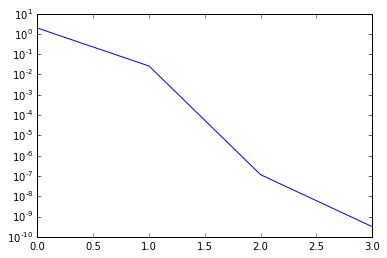

In [61]:
plt.semilogy(errs)